# Analyze cell states vs storage states for Model 1
We want to see if the cell states of Model 1 have learned physically reasonably representations, i.e. storage.

## Data Processing

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import pearsonr

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized data

In [5]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

### Normalized data

In [6]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

In [7]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

## Model 1a

In [8]:
from src.models.model_zoo import *
from src.models.train_model import *
from src.models.analyze_lstm_cell import *

In [9]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1a = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
# load saved model
model1a.load_state_dict(torch.load('src/models/saved_models/model1a.pt'))
# turn model into evaluation model
model1a.eval()

C:\Users\mattc\AppData\Local\Temp\ipykernel_10052\349922000.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1a.load_state_dict(torch.load('src/models/saved_models/

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 30)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

In [10]:
# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values


with torch.no_grad():
    # Get cell states and hidden states 
    # Result is list with one tensor for each layer, shape is (# chunks, timesteps, hidden size)
    hidden_train_1a, cell_train_1a = model1a(X_train_std)[1]
    hidden_val_1a, cell_val_1a = model1a(X_val_std)[1]
    hidden_test_1a, cell_test_1a = model1a(X_test_std)[1]

In [11]:
# Calculate correlations for layer 1
correlation_data = {'training: layer1':cell_correlations(cell_states=cell_train_1a[0], storage_states=storage_train),
                    'validation: layer1': cell_correlations(cell_states=cell_val_1a[0], storage_states=storage_val),
                    'testing: layer1': cell_correlations(cell_states=cell_test_1a[0], storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

# Select cell with |correlation| > 0.40
df_corr.loc[np.abs(df_corr['testing: layer1']) > 0.40, :].sort_values(by='testing: layer1', ascending=False)

,training: layer1,validation: layer1,testing: layer1
20,0.433498,0.630791,0.520652
18,0.412510,0.589280,0.495587
7,0.383135,0.572954,0.482583
29,0.345650,0.562985,0.462216
8,0.308736,0.449046,0.431485
1,-0.362238,-0.489812,-0.452836


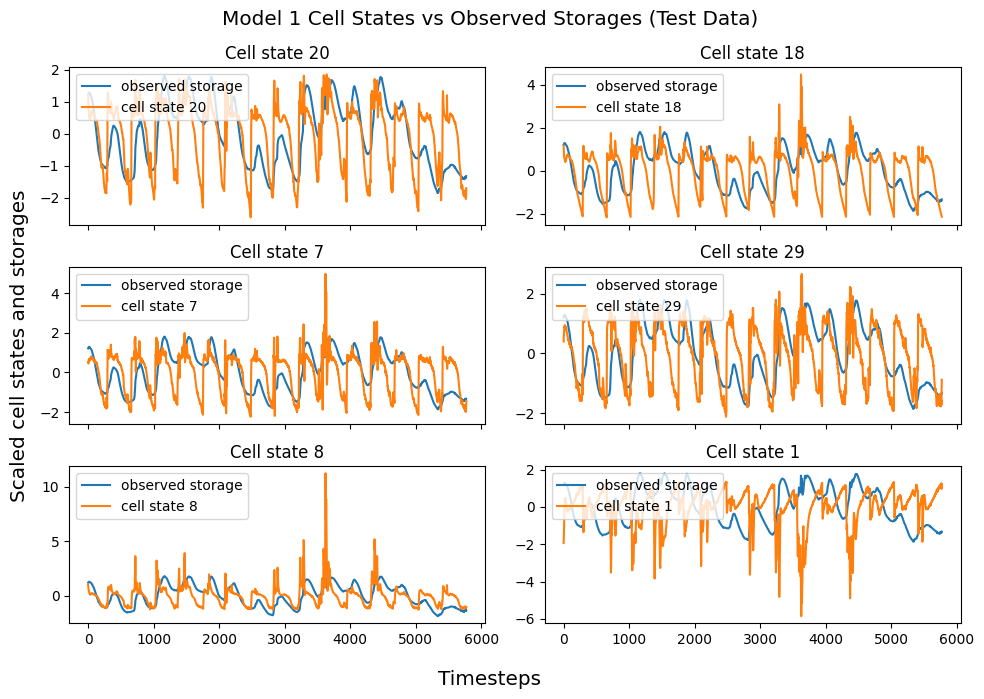

In [12]:
# CHANGE MANUALLY AS NEEDED
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

cell_ids_list = [20, 18, 7, 29, 8, 1]
for i, ax in enumerate(axes.reshape(-1)):
    plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test, cell_id=cell_ids_list[i], ax=ax)
    ax.legend(loc='upper left')
    ax.set_title(f'Cell state {cell_ids_list[i]}')

fig.supxlabel('Timesteps', size='x-large')
fig.supylabel('Scaled cell states and storages', size='x-large')
fig.suptitle('Model 1 Cell States vs Observed Storages (Test Data)', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/figures/model1_shasta_cell_states.png', dpi=300)
plt.show()

In [13]:
def scale_series(x, train_data=None):
    """
    Standardize input series. 
    Params: x - input numpy array
    If train_data is not none, base standardizing statstics on training data
    """
    if train_data is None:
        scaled_series = (x - x[~np.isnan(x)].mean()) / x[~np.isnan(x)].std()
    else:
        scaled_series = (x - train_data[~np.isnan(train_data)].mean()) / train_data[~np.isnan(train_data)].std()

    return scaled_series

In [14]:
def combine_train_val_test_states(state_train, state_val, state_test, len_train, len_val, len_test):
    """ 
    Combine train, val, test cell or hidden states into array of shape (timesteps, hidden size)
    Params:
    state_train, state_val, state_test - input tensors of shape (batches, timesteps, hidden size)
    len_train, len_val, len_test - lengths of train, val, test timesteps (to remove pad from tensors)
    """
    # Remove chunk dimension, convert to numpy (result is shape (timesteps, hidden size))
    state_train, state_val, state_test = flatten_cells(state_train), flatten_cells(state_val), flatten_cells(state_test)
    # Remove pads (from timesteps dimension)
    state_train, state_val, state_test = state_train[:len_train, :], state_val[:len_val, :], state_test[:len_test, :]
    # Combine train, val, test results
    state_all = np.vstack([state_train, state_val, state_test]) # shape (all timesteps, hidden size)
    assert state_all.shape[0] == len_train + len_val + len_test
    return state_all

In [15]:
# Get observed inflow states, shape is (timesteps, )
inflow_train = df.inflow[:original_train_len].values
inflow_val = df.inflow[original_train_len:(original_train_len+original_val_len)].values
inflow_test = df.inflow[(original_train_len+original_val_len):].values

In [16]:
# Get observed outflow states, shape is (timesteps, )
outflow_train = df.outflow[:original_train_len].values
outflow_val = df.outflow[original_train_len:(original_train_len+original_val_len)].values
outflow_test = df.outflow[(original_train_len+original_val_len):].values

In [17]:
# Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train = flatten_rm_pad(predict(model=model1a, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val = flatten_rm_pad(predict(model=model1a, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test = flatten_rm_pad(predict(model=model1a, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
outflow_hat_all = np.concatenate([outflow_hat_train, outflow_hat_val, outflow_hat_test])
assert outflow_train.shape[0] == outflow_hat_train.shape[0]

In [18]:
# Get all cell and hidden states (in shape (timesteps, hidden size))
hidden_all = combine_train_val_test_states(hidden_train_1a[0], hidden_val_1a[0], hidden_test_1a[0],
                                           original_train_len, original_val_len, original_test_len)
cell_all = combine_train_val_test_states(cell_train_1a[0], cell_val_1a[0], cell_test_1a[0],
                                           original_train_len, original_val_len, original_test_len)

### Plot single cell state

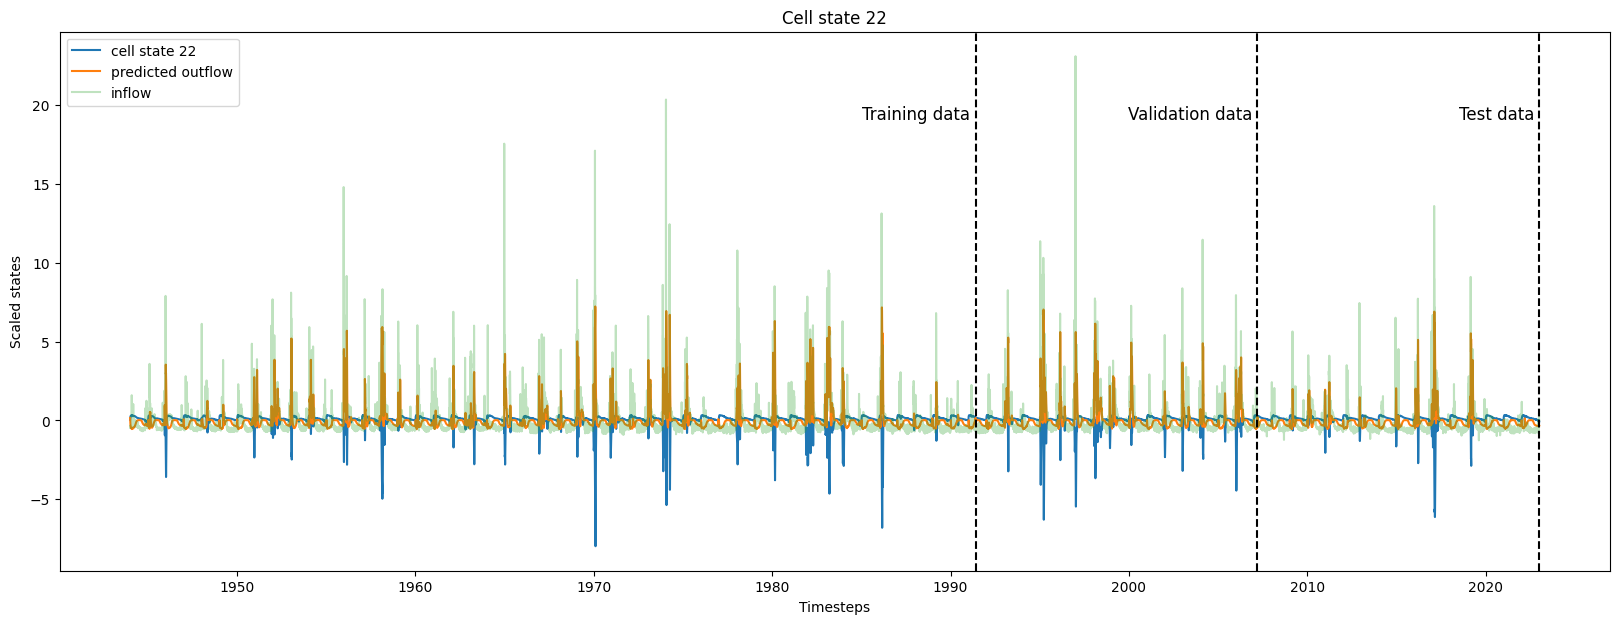

In [19]:
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20, 7))
cell_id = 22
ax.plot(df.index, cell_all[:, cell_id], label=f'cell state {cell_id}')
# ax.plot(scale_series(df.outflow, train_data=outflow_train), label='outflow')
ax.plot(df.index, outflow_hat_all, label='predicted outflow')
ax.plot(scale_series(df.inflow, train_data=inflow_train), label='inflow', alpha=0.3)

ax.axvline(x=df.index[original_train_len - 1], linestyle='--', color='black')
ax.text(x=df.index[original_train_len - 1], y=20, s=f'Training data ', ha='right', va='top', size='large')
ax.axvline(x=df.index[original_train_len + original_val_len - 1], linestyle='--', color='black')
ax.text(x=df.index[original_train_len + original_val_len - 1], y=20, s=f'Validation data ', ha='right', va='top', size='large')
ax.axvline(x=df.index[original_train_len + original_val_len + original_test_len - 1], linestyle='--', color='black')
ax.text(x=df.index[original_train_len + original_val_len + original_test_len - 1], y=20, s=f'Test data ', ha='right', va='top', size='large')

ax.legend()
ax.set_xlabel('Timesteps')
ax.set_ylabel('Scaled states')
ax.set_title(f'Cell state {cell_id}')

plt.show()

## PCA Analysis of Cell States (Test Data)

In [27]:
class PCA:
    """Conduct Principal Components Analysis"""
    def __init__(self, data_matrix):
        self.data = data_matrix # original data of shape (n, # features)
        self.isfit = False
        self.cov_matrix = None # covariance matrix of the data (# features, # features)
        self.Q_matrix = None # matrix of eigenvectors (# features, # features)
        self.eigenvalues = None # array of eigenvalues (# features, )
        return
    
    def fit(self):
        # Standardize the data (so original scale does not affect PCA)
        mean_vals = np.mean(self.data, axis=0)
        std_vals = np.std(self.data, axis=0)
        self.standardized_data = (self.data - mean_vals) / std_vals # (n, # features)

        # Compute covariance matrix 
        self.cov_matrix = np.cov(self.standardized_data.T) # (# features, # features)

        # Spectral (eigen) decompostion
        eigenvalues, Q_matrix = np.linalg.eig(self.cov_matrix) # matrix of eigenvectors of shape (# features, # features)
        # Sort eigenvectors by eigenvalues (descending order)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sorted_indices]
        self.Q_matrix = Q_matrix[:, sorted_indices]
        self.isfit = True
        return
    
    def get_top_k(self, top_k):
        """Select top k Principal Components"""
        assert self.isfit == True
        selected_components = self.Q_matrix[:, :top_k] # (# features, k)
        reduced_data = np.dot(self.standardized_data, selected_components) # shape (n, k)
        return reduced_data

In [30]:
# Conduct PCA on LSTM cell states

# cell_pca = PCA(data_matrix=cell_all)

cell_pca = PCA(data_matrix=flatten_cells(cell_test_1a[0])[:original_test_len, :])
cell_pca.fit()

### Explained Variance
The first three PC's explain 83.93% of total variance

In [32]:
cell_pca.eigenvalues / cell_pca.eigenvalues.sum()

array([4.39261684e-01, 3.15849366e-01, 8.43106511e-02, 5.71956740e-02,
       4.43434275e-02, 2.32694167e-02, 9.77357449e-03, 5.96833656e-03,
       4.66875475e-03, 3.19196606e-03, 3.09908073e-03, 2.46082424e-03,
       1.32762034e-03, 1.17920907e-03, 7.96524340e-04, 7.65738515e-04,
       5.34934450e-04, 4.33931208e-04, 3.33854202e-04, 2.62140582e-04,
       2.04268659e-04, 1.91321464e-04, 1.26545932e-04, 1.24628603e-04,
       1.07076419e-04, 7.40067635e-05, 5.65937737e-05, 3.74477303e-05,
       3.02296534e-05, 2.11723462e-05])

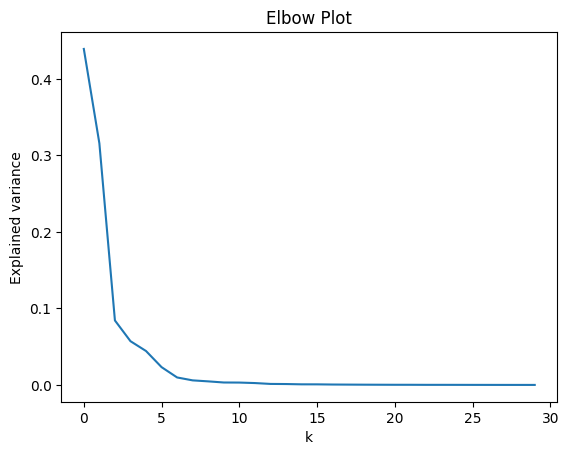

In [33]:
# Elbow plot
fig, ax = plt.subplots()
ax.plot(np.arange(cell_all.shape[1]), (cell_pca.eigenvalues / cell_pca.eigenvalues.sum()))
ax.set_title('Elbow Plot')
ax.set_xlabel('k')
ax.set_ylabel('Explained variance')
plt.show()

### PCA Plots

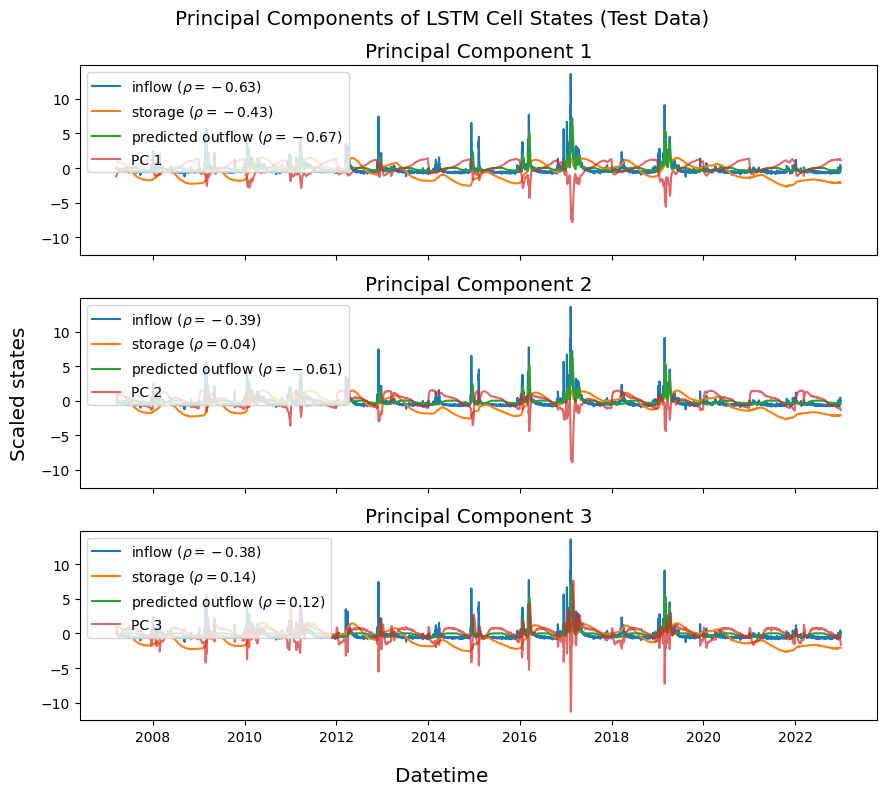

In [87]:
# Plot first 3 principal components of cell states
pca_result = cell_pca.get_top_k(top_k=3) # first 3 PC's of shape (# timesteps, 3)
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(9, 8))

for k in range(pca_result.shape[1]):
    # ax[k].plot(scale_series(df.inflow, train_data=inflow_train), label='inflow', alpha=0.3)
    # ax[k].plot(df.index, outflow_hat_all, label='predicted outflow')
    # ax[k].plot(df.index, scale_series(pca_result[:, k]), label=f'PC {k + 1}', alpha=0.7)

    # Get correlations
    inflow_corr = pearsonr(inflow_test[~np.isnan(inflow_test)], pca_result[:, k][~np.isnan(inflow_test)])[0]
    storage_corr = pearsonr(storage_test[~np.isnan(storage_test)], pca_result[:, k][~np.isnan(storage_test)])[0]
    outflow_corr = pearsonr(outflow_hat_test, pca_result[:, k])[0]


    ax[k].plot(df.index[(original_train_len + original_val_len):], scale_series(inflow_test, train_data=inflow_train), label=f'inflow ($\\rho={round(inflow_corr, 2)}$)')
    ax[k].plot(df.index[(original_train_len + original_val_len):], scale_series(storage_test, train_data=storage_train), label=f'storage ($\\rho={round(storage_corr, 2)}$)')
    ax[k].plot(df.index[(original_train_len + original_val_len):], outflow_hat_test, label=f'predicted outflow ($\\rho={round(outflow_corr, 2)}$)')
    ax[k].plot(df.index[(original_train_len + original_val_len):], scale_series(pca_result[:, k]), label=f'PC {k + 1}', alpha=0.7)

    
    ax[k].legend(loc='upper left')
    ax[k].set_title(f'Principal Component {k + 1}', size='x-large')

# # Label train/val/test data
# for current_ax in ax:
#     current_ax.axvline(x=df.index[original_train_len - 1], linestyle='--', color='black')
#     current_ax.text(x=df.index[original_train_len - 1], y=15, s=f'Training data ', ha='right', va='top', size='large')
#     current_ax.axvline(x=df.index[original_train_len + original_val_len - 1], linestyle='--', color='black')
#     current_ax.text(x=df.index[original_train_len + original_val_len - 1], y=15, s=f'Validation data ', ha='right', va='top', size='large')
#     current_ax.axvline(x=df.index[original_train_len + original_val_len + original_test_len - 1], linestyle='--', color='black')
#     current_ax.text(x=df.index[original_train_len + original_val_len + original_test_len - 1], y=15, s=f'Test data ', ha='right', va='top', size='large')

fig.supxlabel('Datetime', size='x-large')
fig.supylabel('Scaled states', size='x-large')
fig.suptitle('Principal Components of LSTM Cell States (Test Data)',size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/figures/cell_states_pca.png', dpi=300)
plt.show()

In [54]:
# Correlation of PC's with inflow, pred outflow, and storage (in test)
pca_corr = pd.DataFrame(index=np.arange(hidden_size1), columns=['Inflow', 'Predicted Outflow', 'Storage'])
pca_result_all = cell_pca.get_top_k(hidden_size1) # (timesteps, hidden size 1)
for k in range(hidden_size1):
    pca_corr.iloc[k, :] = (np.corrcoef(pca_result_all[-original_test_len:, k], df.fillna(df.iloc[:original_train_len, :].mean()).inflow.values[-original_test_len:])[0, 1],
                           np.corrcoef(pca_result_all[-original_test_len:, k], outflow_hat_test)[0, 1],
                           np.corrcoef(pca_result_all[-original_test_len:, k], df.fillna(df.iloc[:original_train_len, :].mean()).storage.values[-original_test_len:])[0, 1])

In [56]:
pca_corr.iloc[:3, :]

,Inflow,Predicted Outflow,Storage
0,-0.703691,-0.770183,-0.415701
1,0.148639,0.334715,-0.186922
2,-0.423806,0.063744,-0.130603


### Plot sensitivity to single timestep

In [295]:
def input_sensitivity_heatmap(model, output_fun, ax):
    """
    Determine sensitivity of output/hidden/cell state to inputs by inputting one timestep
    Params:
    model - model to evaluate
    output_fun - function with parameters (model, input) that returns desired output (float) given
    a single input timestep (list of features, float)
    ax - matplotlib axes to plot on
    """
    # define grid
    doy = (np.arange(12) + 1) * 30
    doy_scaled_list = (doy - doy.mean()) / doy.std()
    inflow_list = np.arange(-1, 8)

    # get outputs
    result_df = np.zeros(shape=(len(doy), len(inflow_list)))
    for i, doy_scale in enumerate(doy_scaled_list):
        for j, inflow in enumerate(inflow_list):
            result_df[i, j] = output_fun(model, [inflow, doy_scale])
    
    # plot results
    im = ax.imshow(result_df)
    ax.set_yticks(np.arange(len(doy)), labels=doy)
    ax.set_xticks(np.arange(len(inflow_list)), labels=inflow_list)
    ax.set_ylabel('DOY')
    ax.set_xlabel('Scaled Inflow')

    # loop over data dimensions and create text annotations.
    for i in range(len(doy)):
        for j in range(len(inflow_list)):
            text = ax.text(j, i, round(result_df[i, j], 2),
                        ha="center", va="center", color="w")
    
    # create color bar
    cbar = ax.figure.colorbar(im, fraction=0.046, ax=ax)
    cbar.ax.set_ylabel('Output', rotation=-90, va="bottom")

    return result_df

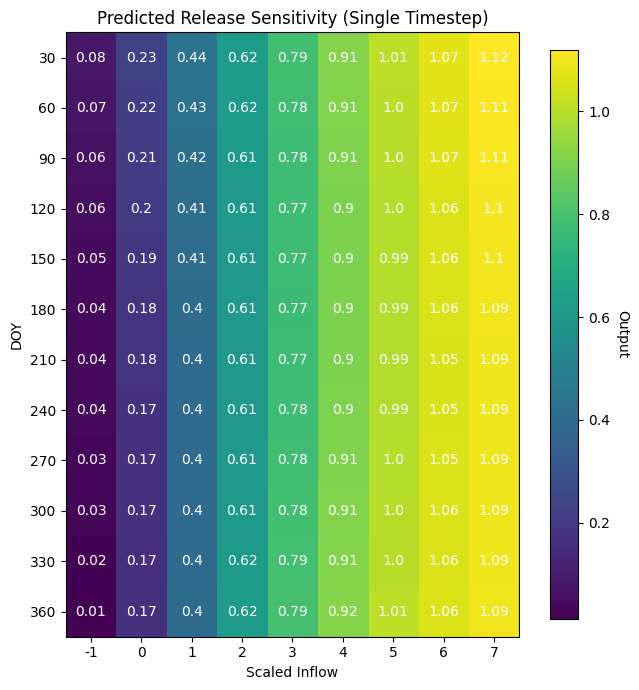

In [331]:
fig, ax = plt.subplots(figsize=(7, 7))
def output_function(model, input_list):
    input_tensor = torch.tensor([[input_list]], dtype=torch.float32)
    with torch.no_grad():
        out, (c, h) = model(input_tensor)
        return out[0, 0, 0]
result_df = input_sensitivity_heatmap(model=model1a, output_fun=output_function, ax=ax)
ax.set_title('Predicted Release Sensitivity (Single Timestep)')
plt.tight_layout()
plt.show()

### What about longer term correlations? (Model 1a)
Try correlating with moving averages to see if cell states correlate with smoothed states

In [48]:
# Get yearly moving average of storage
storage_train_1yrma = pd.DataFrame(storage_train).rolling(window=365).mean().values
storage_val_1yrma = pd.DataFrame(storage_val).rolling(window=365).mean().values
storage_test_1yrma = pd.DataFrame(storage_test).rolling(window=365).mean().values

In [49]:
# Calculate correlations for layer 1 (with 1 year MA storages)
correlation_data_1yrma = {'training: layer1':cell_correlations(cell_states=cell_train_1a[0], storage_states=storage_train_1yrma),
                    'validation: layer1': cell_correlations(cell_states=cell_val_1a[0], storage_states=storage_val_1yrma),
                    'testing: layer1': cell_correlations(cell_states=cell_test_1a[0], storage_states=storage_test_1yrma)}
df_corr_1yrma = pd.DataFrame(correlation_data)

# Select cell with correlation > 0.30
df_corr_1yrma.loc[df_corr['training: layer1'] > 0.40, :].sort_values(by='testing: layer1', ascending=False)

,training: layer1,validation: layer1,testing: layer1
20,0.433498,0.630791,0.520652
18,0.412510,0.589280,0.495587


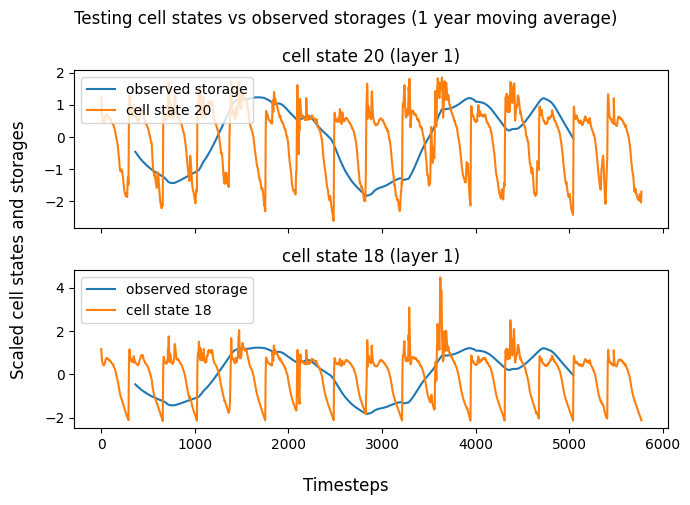

In [51]:
# CHANGE MANUALLY AS NEEDED
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test_1yrma, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test_1yrma, cell_id=18, ax=axes[1])
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[0].set_title('cell state 20 (layer 1)')
axes[1].set_title('cell state 18 (layer 1)')
fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Testing cell states vs observed storages (1 year moving average)')
plt.tight_layout()
plt.show()